In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
from torch import nn
from torch import optim

import torchvision.transforms as T
import matplotlib.pyplot as plt



from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from datasets.nom_dataset import NomDataset
from models.model import Model
# from PIL import Image
# import numpy as np
# from utils.utils import image_padder
# from pathlib import Path
# from tqdm import tqdm
# import cv2

/home/pmphan/Projects/nom-recognization/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
model = Model(3460)

In [22]:
model

Model(
  (stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(i

In [58]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [7]:
dataset = NomDataset(['tale-of-kieu', 'Luc-Van-Tien'], transform, target_transform)

In [8]:
len(dataset.alphabet_dict)

3460

In [59]:
# # # Generate processed image - do not execute
# files = ['tale-of-kieu', 'Luc-Van-Tien']

# for file in files:
#     root = Path(f"./images/{file}/")
#     imgs = root.glob("*.jpg")
#     for img in tqdm(imgs):
#         if img.exists():    
#             image = np.asarray(Image.open(img))
#             padded = Image.fromarray(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
#             padded.save(img)
#             break

# plt.imshow(np.asarray(padded))

In [15]:
transform = T.Compose([T.ToTensor()])
target_transform = lambda y: torch.LongTensor(y)
dataset = NomDataset(['tale-of-kieu'], transform, target_transform)

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=4).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    show_images(next(iter(dl))[0], nmax)

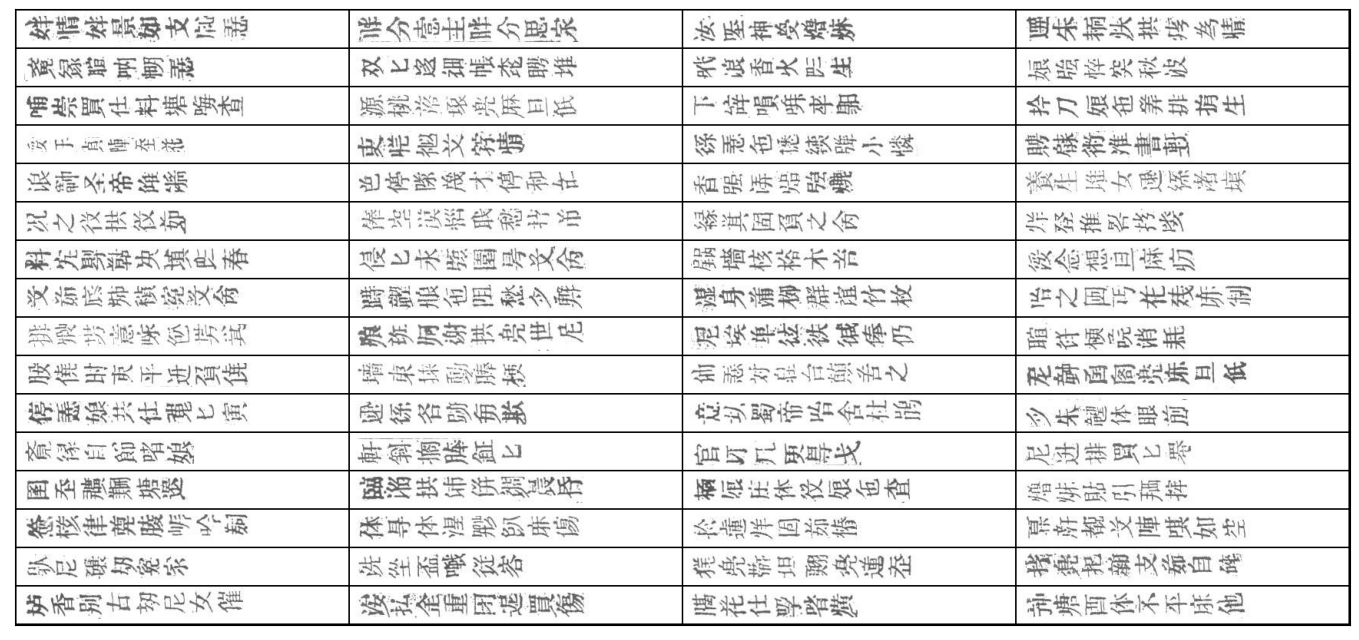

In [17]:
dl = DataLoader(dataset, 64, shuffle=True, num_workers=4, pin_memory=True)
show_batch(dl)

In [90]:
N = 64
dataset = NomDataset(['tale-of-kieu', 'Luc-Van-Tien'], transform, target_transform)
NCLASS = len(dataset.alphabet_dict)

model = Model(NCLASS).to(device)

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=N, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=N, shuffle=True, num_workers=4, pin_memory=True)

loss_fn = nn.CTCLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

In [94]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y, length) in enumerate(dataloader):
        model.train()
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y, torch.IntTensor([pred.shape[0]] * pred.shape[1]), length) / N

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y, l in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y, torch.IntTensor([pred.shape[0]] * pred.shape[1]), l).item() / N
            # Wrong calculation method
            correct += (pred.argmax(2).permute(1, 0) == y).type(torch.float).sum().item() / 13

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [1]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


NameError: name 'train_loop' is not defined